In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
!pip install tensorflow

In [3]:
#import non tensorflow libraries
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import pathlib
import IPython.display as display

#import tensorflow libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

****Data Preparation****

In [4]:
#initialise class names and view them
with open("/content/drive/MyDrive/audit_ai/document-dataset/meta/classes.txt", "r") as f:
    CLASS_NAMES = [item.strip() for item in f]
CLASS_NAMES = np.array(CLASS_NAMES)
print(len(CLASS_NAMES))

3


In [5]:
#initialising necessary properties
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(10000/BATCH_SIZE)

#prepare train data generator with necessary augmentations and validation split
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.25)

In [6]:
#initialise train directory
data_dir = '/content/drive/MyDrive/audit_ai/document-dataset/images'
data_dir = pathlib.Path(data_dir)

In [7]:
#generate training data
print('Train Data')
train_data = train_datagen.flow_from_directory(
    str(data_dir),
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes = list(CLASS_NAMES),
    subset='training')

#generate validation data
print('\nValidation Data')
valid_data = train_datagen.flow_from_directory(
    str(data_dir),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset='validation')

Train Data
Found 2513 images belonging to 3 classes.

Validation Data
Found 837 images belonging to 3 classes.


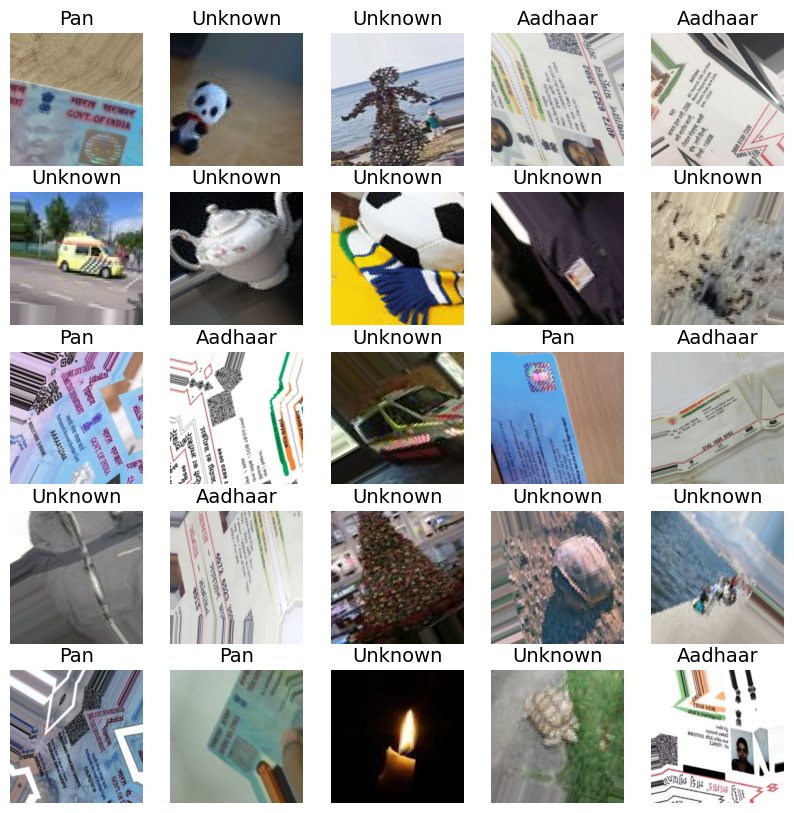

In [8]:
#vizualise the loaded images
def show_batch(image_batch, label_batch):
  fig = plt.figure(figsize=(10,10))
  fig.patch.set_facecolor('white')
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title(), fontsize=14)
      plt.axis('off')
image_batch, label_batch = next(train_data)
show_batch(image_batch, label_batch)

In [9]:
#import model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [10]:
#initialise base model
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
base_model = MobileNetV2(input_shape=IMG_SHAPE, input_tensor=None,
                                                include_top=False,
                                                weights='imagenet')
base_model.trainable = True

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
#define model
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
#compile model
model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.001, momentum=0.9),
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False),
      metrics=['accuracy'])
model.summary()

ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.

In [16]:
epochs = 30

# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)
#fit the model
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data = valid_data,
                    callbacks=[early_stopper, reduce_lr])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 9/79 ━━━━━━━━━━━━━━━━━━━━ 10:52 9s/step - accuracy: 0.4320 - loss: 1.1236

KeyboardInterrupt: 

Save the Model

In [ ]:
model.save("/content/drive/MyDrive/audit_ai/audit_model.keras")

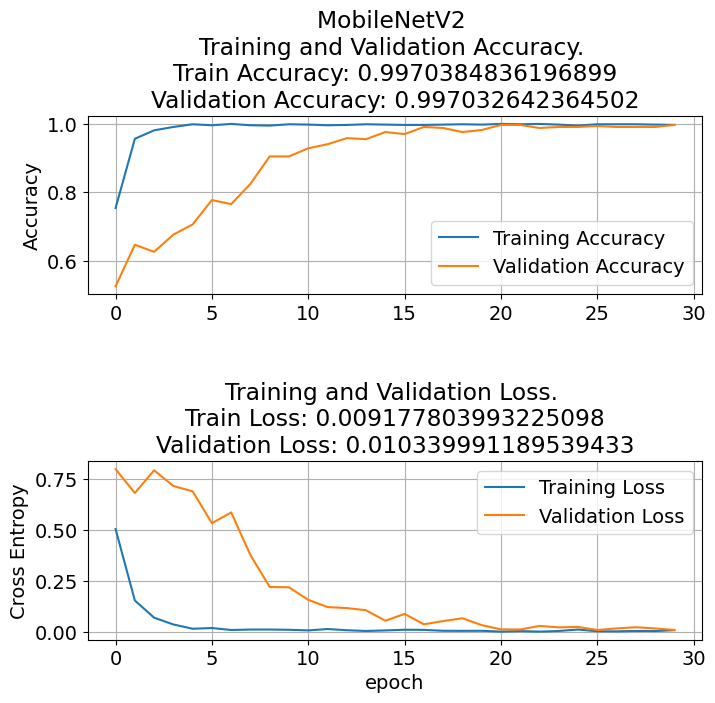

In [ ]:
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

Test the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 5
TEST_DIR = "./test"

# Load the saved model
model = load_model("/content/drive/MyDrive/audit_ai/audit_model.h5")


def predict_image(image_path):
    class_labels = ["aadhaar", "pan"]
    try:
        img = tf.keras.utils.load_img(image_path, target_size=IMG_SIZE)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Create a batch
        img_array /= 255.0  # Rescale the image to [0, 1]

        prediction = model.predict(img_array)
        predicted_class = class_labels[np.argmax(prediction)]
        confidence = np.max(prediction)

        print(f"Prediction: {prediction}")
        print(f"Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}")
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

In [ ]:
predict_image("/content/drive/MyDrive/audit_ai/document-dataset/test_model/pan2.jpg")

1/1 [==============================] - 0s 25ms/step
Prediction: [[0.03219261 0.9678074 ]]
Predicted class: pan
Confidence: 0.97
